# Atmospherically Corrected Earth Engine Time Series 

### Overview

This notebook creates atmospherically corrected time series of satellite imagery using [Google Earth Engine](https://earthengine.google.com/) and the [6S emulator](https://github.com/samsammurphy/6S_emulator). 

### Supported missions

* Sentintel2
* Landsat8
* Landsat7
* Landsat5
* Landsat4

### Output

Average, cloud-*free* pixel values 

### Cloud masking

Uses standard cloud masks, i.e. FMASK for Landsat and ESA-QA60 for Sentinel 2.  There is no guarantee they will find all clouds, a discussion on more advance and/or alternative cloud masking strategies is available [here](https://groups.google.com/forum/#!searchin/google-earth-engine-developers/cloud$20AND$20sentinel2%7Csort:relevance/google-earth-engine-developers/i63DS-Dg8Sg/FWenONUFBwAJ)

#### Initialize

In [7]:
# standard modules
import os
import sys
import ee
import colorsys
from IPython.display import display, Image
%matplotlib inline
ee.Initialize()

# custom modules
base_dir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(base_dir,'atmcorr'))
from kml_reader import read_kml
from timeSeries import timeSeries
from postProcessing import postProcessing
from plots import plotTimeSeries

In [8]:
#debuggin
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### User Input

In [9]:
target = 'CraterLake'
geom = read_kml('IAVCEI.kml', target)

# start and end of time series
startDate = '1990-01-01'# YYYY-MM-DD
stopDate  = '2017-01-01'# YYYY-MM-DD

# satellite missions
missions = ['Sentinel2', 'Landsat8', 'Landsat7', 'Landsat5', 'Landsat4']

### All time series
This function extracts cloud-free time series for each mission, atmospherically corrects them and joins them together

In [10]:
allTimeSeries = timeSeries(target, geom, startDate, stopDate, missions)

Loading interpolated look up tables (.ilut) for Sentinel2..
Success
Getting data from Earth Engine.. 
Data collection complete
number of valid images = 21
Running atmospheric correction
Done
Loading interpolated look up tables (.ilut) for Landsat8..
Success
Getting data from Earth Engine.. 
Data collection complete
number of valid images = 72
Running atmospheric correction
Done
Loading interpolated look up tables (.ilut) for Landsat7..
Success
Getting data from Earth Engine.. 
Data collection complete
number of valid images = 315
Running atmospheric correction
Done
Loading interpolated look up tables (.ilut) for Landsat5..
Success
Getting data from Earth Engine.. 
Data collection complete
number of valid images = 332
Running atmospheric correction
Done
Loading interpolated look up tables (.ilut) for Landsat4..
Success
Getting data from Earth Engine.. 
Data collection complete


### Data post-processing
Resample into daily intervals using liner interpolation and calculate hue-saturation-value from RGB.

In [11]:
DF = postProcessing(allTimeSeries, startDate, stopDate)

### Hue Stretch
We visualize *hue* by taking a [HSV](http://infohost.nmt.edu/tcc/help/pubs/colortheory/web/hsv.html) color triplet and 'strecthing' the *saturation*  and *value* (i.e. setting them to 1) then converting the new 'stretched' HSV color-triplet back into RGB for display on the screen.

In [12]:
hue_stretch = [colorsys.hsv_to_rgb(hue,1,1) for hue in DF['hue']]

### bringing it all together...
make a pretty graph to help us do some science.

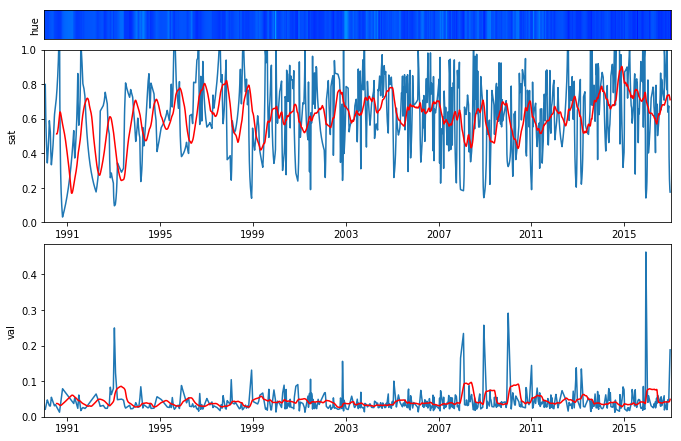

In [13]:
plotTimeSeries(DF, hue_stretch, startDate, stopDate)

Thue hue looks kinda like tree rings through time..

..may be useful for phenology and/or wavelet analysis?